# Exploring simulation data and defining threshold
for manuscript recent selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Function to reconstruct data from histogram
def reconstruct_data(bin_start, bin_end, counts):
    midpoints = (bin_start + bin_end) / 2  # Calculate bin midpoints
    data = np.repeat(midpoints, counts)    # Repeat midpoints based on counts
    return data

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# Read the first CSV file
ana_dir = "/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex"


PBS_FN = f"{ana_dir}/analyses/sim_fishery/output/null_histogram_PBS.csv"
histPBS = pd.read_csv(PBS_FN, header = None)

# Read the second CSV file
HSCAN_FN = f"{ana_dir}/analyses/sim_fishery/output/null_histogram_hscan.csv"
histHSCAN = pd.read_csv(HSCAN_FN, header = None)

In [3]:
dataPBS = reconstruct_data(histPBS.iloc[:, 1], histPBS.iloc[:, 2], histPBS.iloc[:, 3])

dataHSCAN = reconstruct_data(histHSCAN.iloc[:, 1], histHSCAN.iloc[:, 2], histHSCAN.iloc[:, 3])

In [4]:
dataPBS_np = dataPBS.to_numpy()
dataHSCAN_np = dataHSCAN.to_numpy()

In [5]:
dataPBS_np

array([5.00467885e-07, 5.00467885e-07, 5.00467885e-07, ...,
       9.77825424e-01, 1.00070147e+00, 1.00070147e+00])

## Read in simulated data

In [6]:
import glob


def load_and_combine_to_df(npy_files):
    all_dfs = []
    for file in npy_files:
        arr = np.load(file)
        if arr.ndim == 2 and arr.shape[1] == 2:
            df = pd.DataFrame(arr, columns=["PBS", "H"])
            all_dfs.append(df)
        else:
            print(f"Skipping {file}, unexpected shape {arr.shape}")
    return pd.concat(all_dfs, ignore_index=True)

# Example usage:
files = glob.glob(f"{ana_dir}/analyses/sim_fishery/output/*.npy")  # or provide a list of specific files
print(files)
print(len(files))
df_sim = load_and_combine_to_df(files)


['/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/analyses/sim_fishery/output/507.npy', '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/analyses/sim_fishery/output/510.npy', '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/analyses/sim_fishery/output/504.npy', '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/analyses/sim_fishery/output/502.npy', '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/analyses/sim_fishery/output/509.npy', '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/analyses/sim_fishery/output/506.npy', '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/analyses/sim_fishery/output/505.npy', '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/analyses/sim_fishery/output/503.npy', '/scratch/antwerpen/grp/asvardal/projec

### Calculate FCS of simulated data

In [7]:
from scipy.stats import rankdata

df_sim['PBS_percentile'] = rankdata(-df_sim['PBS'], method='average') / len(df_sim)
df_sim['h_scores_percentile'] = rankdata(-df_sim['H'], method='average') / len(df_sim)

In [8]:
df_sim['PBS_log_rank'] = -np.log10(df_sim['PBS_percentile'])
df_sim['h_scores_log_rank'] = -np.log10(df_sim['h_scores_percentile'])

In [9]:
df_sim['FCS'] = df_sim['PBS_log_rank'] + df_sim['h_scores_log_rank']

## read in merged data

In [10]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
#import colorbrewer
import yaml
from gtfparse import read_gtf
from matplotlib.backends.backend_pdf import PdfPages

import sys 
sys.path.append("/data/antwerpen/grp/asvardal/hs_tools")
from pypopgen3.modules import vcfpandas as vp

typedict = {'CHROM':'category', 'H':'float16', 'PBS_pop1':'float16', 'z_score':'float16', 'modified_z_score':'float16', 'squared_z_score':'float16'}


import subprocess

eu = os.path.expanduser
jn = os.path.join
ap = os.path.abspath

chrom_len = pd.read_csv('/scratch/antwerpen/grp/asvardal/projects/cichlid/reference/fAstCal1.2/GCA_900246225.3_fAstCal1.2_genomic_chromnames_mt.fa.fai',
                           sep='\t', usecols=[0,1], names=['chrom','len'], index_col=0).squeeze("columns")

chromosomes = ['chr' + str(i)for i in range(1,24) if i != 21]

In [11]:
ana_dir = '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex'
out_dir_hscan = '/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/output/hscan'
cichlid_dir = '/scratch/antwerpen/grp/asvardal/projects/cichlid'
out_dir_fst = "/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex/output/fst"


def read_pbs(fn):
    fst_df = pd.read_csv(fn,sep='\t',index_col=[0,1]).dropna().squeeze("columns")
    return fst_df

hscan_subset_id = 'virginalis_Malombe-Nkhudzi'
pbs_trio = 'Malombe--Nkhudzi-SE_arm'
region_id = 'wg'
species = 'virginalis'

sfilter = 'pass.snps.biallelic'
# sfilter = 'NoSFilter.snps.biallelic'

dmode = 'd-1'

# windows = 100000

# print(f"{out_dir_hscan}/H_out.{subset_id}.{sfilter}.whatshap.shapeit4.annotate.chr1_{dmode}.tsv")

In [12]:
wg_pbs_df = read_pbs(f"{out_dir_fst}/PBS_{species}.{pbs_trio}.{region_id}.weir.fst")

In [13]:
f = lambda x: -np.log(1-x)
wg_pbs_df["PBS_log_pop1"] = 0.5 * (f(wg_pbs_df["12_WEIR_AND_COCKERHAM_FST"]) + f(wg_pbs_df["13_WEIR_AND_COCKERHAM_FST"]) - f(wg_pbs_df["23_WEIR_AND_COCKERHAM_FST"]))

/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
dfs = []
for chrom in chromosomes:
    fn = f"{out_dir_hscan}/H_out.{hscan_subset_id}.{sfilter}.whatshap.shapeit4.annotate.{chrom}_{dmode}.tsv"
    df = pd.read_csv(fn,sep='\t',index_col=[0])
    df['chrom'] = chrom
    dfs.append(df)

wg_hscan_df = pd.concat(dfs).reset_index().set_index(['chrom', 'x'])

In [15]:
merged_H_PBS = pd.merge(wg_hscan_df.reset_index(), wg_pbs_df.reset_index(), left_index=True, right_index=True)

In [16]:
merged_H_PBS = merged_H_PBS.set_index(['chrom', 'x'])

In [17]:
from scipy.stats import rankdata
# Compute percentile ranks (scaled between 0 and 1)
merged_H_PBS['PBS_percentile'] = rankdata(-merged_H_PBS['PBS_log_pop1'], method='average') / len(merged_H_PBS)
merged_H_PBS['h_scores_percentile'] = rankdata(-merged_H_PBS['H'], method='average') / len(merged_H_PBS)

In [18]:
# Compute -log10 of the percentile ranks
merged_H_PBS['PBS_log_rank'] = -np.log10(merged_H_PBS['PBS_percentile'])
merged_H_PBS['h_scores_log_rank'] = -np.log10(merged_H_PBS['h_scores_percentile'])

In [19]:
# sum log rank
merged_H_PBS['FCS'] = merged_H_PBS['PBS_log_rank'] + merged_H_PBS['h_scores_log_rank']

## Plot output an threshold determination

In [20]:
FCS_real = merged_H_PBS['FCS'].to_numpy()

In [21]:
FCS_sim = df_sim['FCS'].to_numpy()

In [25]:
from scipy.stats import skew, kurtosis
print("Skewness of Dataset 1:", skew(FCS_real))
print("Skewness of Dataset 2:", skew(FCS_sim))
print("Kurtosis of Dataset 1:", kurtosis(FCS_real))
print("Kurtosis of Dataset 2:", kurtosis(FCS_sim))

Skewness of Dataset 1: 1.540030322491572
Skewness of Dataset 2: 1.5160204244568665
Kurtosis of Dataset 1: 3.888634079224982
Kurtosis of Dataset 2: 3.5492030981168066


In [28]:
# Sort both datasets
FCS_real_sorted = np.sort(FCS_real)
FCS_sim_sorted = np.sort(FCS_sim)

# Downsample the larger one to match the smaller one's length
n = min(len(FCS_real_sorted), len(FCS_sim_sorted))
# Randomly sample n values without replacement from each dataset
FCS_real_sample = np.sort(np.random.choice(FCS_real, size=n, replace=False))
FCS_sim_sample  = np.sort(np.random.choice(FCS_sim,  size=n, replace=False))

In [29]:
# Now compute residuals (real - sim) at matched quantiles
residuals = FCS_real_sample - FCS_sim_sample

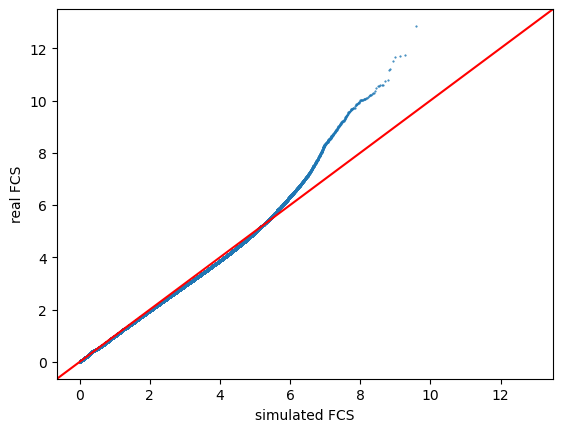

In [30]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt

pp_real = sm.ProbPlot(FCS_real)
pp_sim = sm.ProbPlot(FCS_sim)
qqplot_2samples(pp_real, pp_sim, line='45', xlabel="real FCS", ylabel="simulated FCS")

ax = plt.gca()  # get current axes
for line in ax.lines:
    line.set_markersize(0.5)  # or try 0.5, 2, etc. depending on density
plt.show()


^ Deviation from 45 degree line (5<FCS<6) indicates axis coordinate where matched percentile value for real FCS are higher than simulated FCS 

/tmp/ipykernel_3235819/2854386998.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_3235819/2854386998.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


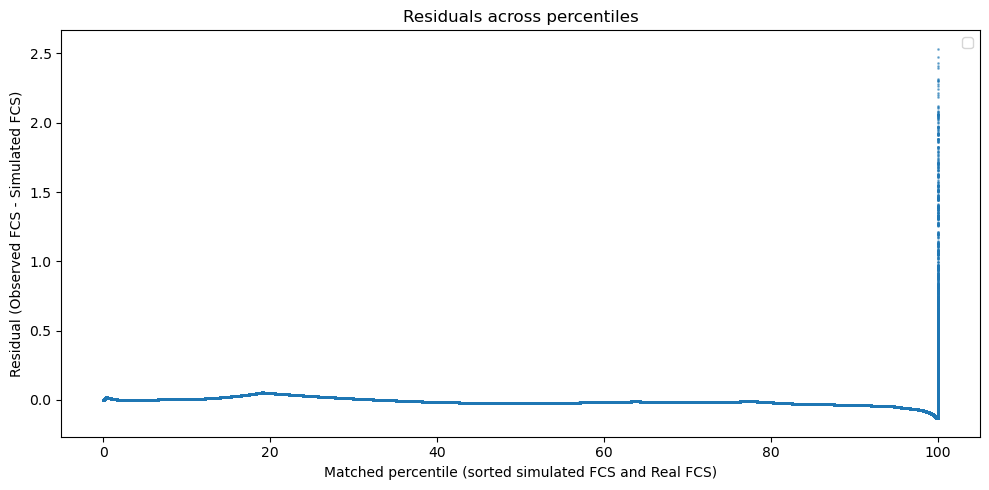

In [31]:
percentiles = np.linspace(0, 100, len(residuals))

plt.figure(figsize=(10, 5))
plt.plot(percentiles, residuals, '.', alpha=0.5, markersize=2)
plt.xlabel("Matched percentile (sorted simulated FCS and Real FCS)")
plt.ylabel("Residual (Observed FCS - Simulated FCS)")
plt.title("Residuals across percentiles")
plt.legend()
plt.tight_layout()
plt.show()


Deviation even more visable in residucal plot, showing that at highest percentile the residual (deviation from the 45 degree line) increases excessivly.

In [45]:
# Loop over several high-percentile thresholds to approximatly the point where the excessive increase in the highest percentile is above the "20% peak"
for p in [99.95, 99.96, 99.97, 99.98, 99.985, 99.99, 99.995]:
    threshold = np.percentile(residuals, p)
    cutoff_index = np.where(residuals > threshold)[0][0]
    FCS_cutoff = FCS_real_sample[cutoff_index]
    print(f"{p}% → FCS cutoff = {FCS_cutoff:.6f}, residual = {residuals[cutoff_index]:.6f}")


99.95% → FCS cutoff = 0.393287, residual = 0.054117
99.96% → FCS cutoff = 0.393370, residual = 0.054153
99.97% → FCS cutoff = 0.393448, residual = 0.054191
99.98% → FCS cutoff = 0.393527, residual = 0.054225
99.985% → FCS cutoff = 0.393565, residual = 0.054242
99.99% → FCS cutoff = 5.512058, residual = 0.072298
99.995% → FCS cutoff = 6.029348, residual = 0.214941


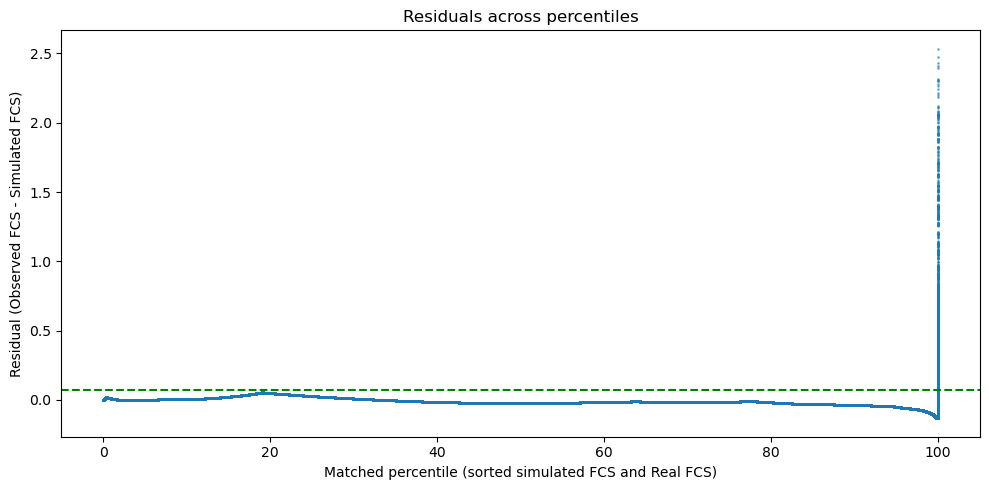

In [50]:
percentiles = np.linspace(0, 100, len(residuals))

plt.figure(figsize=(10, 5))
plt.plot(percentiles, residuals, '.', alpha=0.5, markersize=2)

# Add horizontal line at y = threshold

plt.axhline(y=np.percentile(residuals, 99.99), color='green', linestyle='--', label='99.99% cutoff')

plt.xlabel("Matched percentile (sorted simulated FCS and Real FCS)")
plt.ylabel("Residual (Observed FCS - Simulated FCS)")
plt.title("Residuals across percentiles")
# plt.legend()
plt.tight_layout()
plt.show()



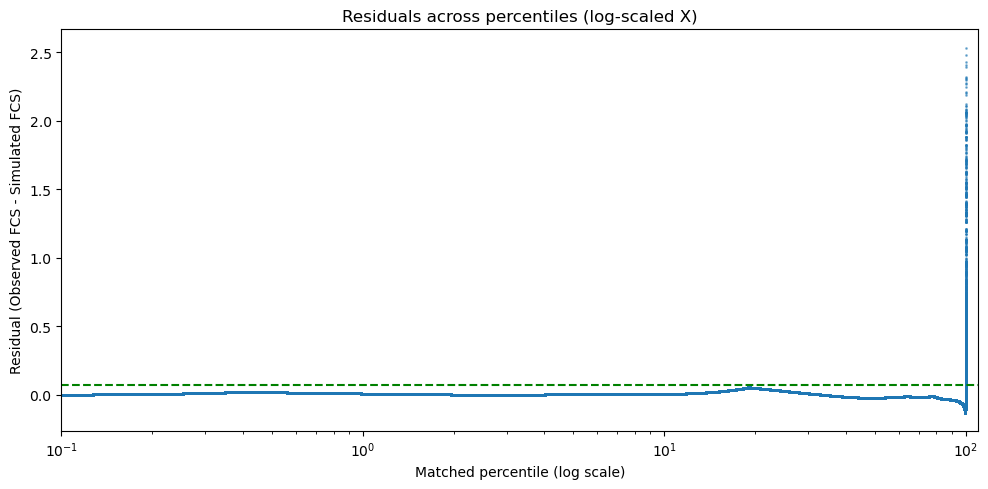

In [77]:
percentiles = np.linspace(0, 100, len(residuals))

plt.figure(figsize=(10, 5))
plt.plot(percentiles, residuals, '.', alpha=0.5, markersize=2)

# Add horizontal line at y = threshold
plt.axhline(y=np.percentile(residuals, 99.99), color='green', linestyle='--', label='99.99% cutoff')

plt.xscale('log')  # <<< log-corrected X axis
plt.xlim(0.1, 110)  # avoid log(0) error, shift slightly away from 0

plt.xlabel("Matched percentile (log scale)")
plt.ylabel("Residual (Observed FCS - Simulated FCS)")
plt.title("Residuals across percentiles (log-scaled X)")
plt.tight_layout()
plt.show()

99.99 percentile appropriate

## Figure 3C

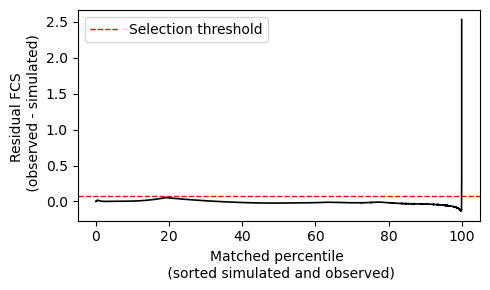

In [70]:
percentiles = np.linspace(0, 100, len(residuals))
# smoothed = uniform_filter1d(residuals, size=200)  # moving average

plt.figure(figsize=(5, 3))
plt.plot(percentiles, residuals, color="black", linewidth=1.2)
plt.axhline(
    y=np.percentile(residuals, 99.99),
    color='red', linestyle='--', linewidth=1,
    label='Selection threshold'
)
# plt.axvline(x=99.99, color='green', linestyle='--', label='99.99% cutoff')
plt.xlabel("Matched percentile \n (sorted simulated and observed)")
plt.ylabel("Residual FCS \n (observed - simulated)")
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig(f"{ana_dir}/Output/Figures/residuals_simulation.pdf", bbox_inches="tight")
plt.show()


## Supplementary figure S1

In [73]:
threshold = np.percentile(residuals, 99.99)
cutoff_index = np.where(residuals > threshold)[0][0]
FCS_cutoff = FCS_real_sample[cutoff_index]


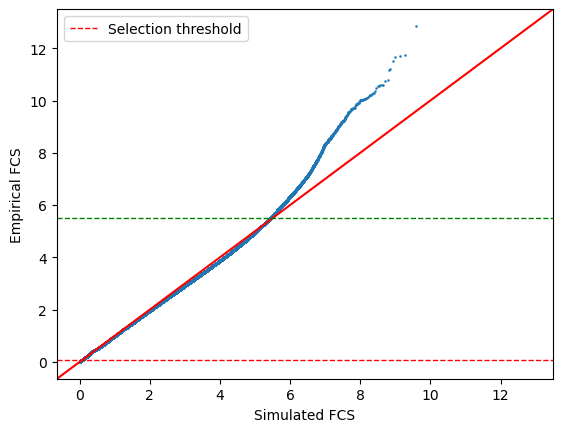

In [74]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt

# Generate the QQ plot
pp_real = sm.ProbPlot(FCS_real)
pp_sim = sm.ProbPlot(FCS_sim)
fig = qqplot_2samples(pp_real, pp_sim, line='45',
                      xlabel="Empirical FCS", ylabel="Simulated FCS")

ax = plt.gca()

# Rasterize the dense point data only
for line in ax.lines:
    line.set_rasterized(True)
    line.set_markersize(0.8)  # keep small dots

# Add horizontal line at threshold (vector)
plt.axhline(y=FCS_cutoff, color='green', linestyle='--',
            linewidth=1, label='99.99% selection threshold')
plt.axhline(
    y=np.percentile(residuals, 99.99),
    color='red', linestyle='--', linewidth=1,
    label='Selection threshold'
)
# Keep legend/labels as vectors
plt.legend(handles=[ax.lines[-1]], loc='upper left')

# Save with mixed raster/vector
plt.savefig(f"{ana_dir}/Output/Figures/Supp_S1.pdf",
            bbox_inches="tight")

plt.show()
